## Data Preperation and Modeling

Preperation

* Set the Stage for Binary Classifier
* Resizing Images
* Data Handling
* Balancing Data
* Train Test Spliting
* Data Augmentation

Modeling

* Neural Net Architecture
* Model Training, 5 Fold Cross Validtion
* Training/Validation Accuracy and Loss
* Test Data Evaluation
 - Prdiction
 - Confusion Matrix
 - ROC Curve
 - ROC Curve Comparison

### Import the Required Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path
import os
import shutil
from zipfile import ZipFile
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics
from PIL import Image
from tensorflow.keras.metrics import AUC
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from PIL import Image
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score

In [ ]:
# Extract all the contents of zip file in current directory
with ZipFile('Patients_CT.zip', 'r') as zipObj:
   zipObj.extractall()

In [ ]:
# Read csv file
df=pd.read_csv('Patients_CT/hemorrhage_diagnosis.csv')
print(df.shape)
df.head()

(2501, 9)


,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


## Set the Stage for Binary Classifier  
This code snippet serves the purpose of sorting and classifying CT images into distinct folders depending on their labels (0 or 1) by utilizing data from a CSV file. It not only guarantees the presence of the intended destination folders but also manages the image copying process to ensure accurate arrangement.

In [ ]:
# Function to create a folder if it doesn't exist
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Function to copy images to their respective folders
def copy_images(csv_file, folder_0, folder_1):
    df = pd.read_csv(csv_file )
    df['Image'] = "/content/Patients_CT/"+df.iloc[:, 0].astype(str) + '/brain/'+ df.iloc[:, 1].astype(str)+'.jpg'

    # Create destination folders if they don't exist
    create_folder_if_not_exists(folder_0)
    create_folder_if_not_exists(folder_1)

    # Loop through each row in the CSV and copy images to appropriate folders
    for index, row in df.iterrows():
        image_name = row['Image']

        label = row['No_Hemorrhage']

        source_path = os.path.join(image_name)
        aux = image_name.split('/')[-3:]
        des = ""
        for i in aux:
            des += i
        if label == 0:
            destination_path = os.path.join(folder_0, des)
        elif label == 1:
            destination_path = os.path.join(folder_1, des)
        else:
            # Skip if the label is not 0 or 1
            continue

        # Copy the image to the respective folder
        shutil.copy(image_name, destination_path)

# Set the paths and filenames
csv_file = "/content/Patients_CT/hemorrhage_diagnosis.csv"
folder_0 = "folder_for_label_0"
folder_1 = "folder_for_label_1"

# Call the function to copy the images
copy_images(csv_file, folder_0, folder_1)

In [ ]:
# Number of images with hemorrhage
folder_hemo = os.listdir('folder_for_label_0')

# Number of images without hemorrhage
folder_no_hemo = os.listdir('folder_for_label_1')

print( 'Number of images with hemorrhage is:',len(folder_hemo))
print( 'Number of images without hemorrhage is:',len(folder_no_hemo))

Number of images with hemorrhage is: 318
Number of images without hemorrhage is: 2183


## Control Room

In [ ]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width,Image_Height)
Image_Channels = 1
nonhemorrhage = Path('/content/folder_for_label_1/')
hemorrhage = Path('/content/folder_for_label_0/')
num_epochs = 20


### Resizing Images
This code snippet allows users to provide a folder containing images and specify a target width and height for resizing those images. The script then iterates through each image in the folder, resizes it to the provided dimensions while applying anti-aliasing, and saves the resized image, effectively replacing the original image. Images resized from 650 * 650 pixels to 128 * 128 pixels.

In [ ]:
print("Shrink images in the folder")
folder = input("folder: ")
w = int(input("width: "))
h = int(input("height: "))
for i in os.listdir(folder):
    file = f"{folder}/{i}"
    im = Image.open(file)
    im = im.resize((w, h), Image.ANTIALIAS)
    im.save(file)

Shrink images in the folder
folder: /content/folder_for_label_0
width: 128
height: 128


<ipython-input-7-08c4f6fbf8b7>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((w, h), Image.ANTIALIAS)


In [ ]:
print("Shrink images in the folder")
folder = input("folder: ")
w = int(input("width: "))
h = int(input("height: "))
for i in os.listdir(folder):
    file = f"{folder}/{i}"
    im = Image.open(file)
    im = im.resize((w, h), Image.ANTIALIAS)
    im.save(file)

Shrink images in the folder
folder: /content/folder_for_label_1
width: 128
height: 128


<ipython-input-9-08c4f6fbf8b7>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((w, h), Image.ANTIALIAS)


## Data Handling
This code snippet prepares and structures CT image file paths and corresponding labels into a consolidated DataFrame for further analysis. We now possess a DataFrame that comprises the file paths of CT images as rows along with their corresponding labels.

In [ ]:
nonhemorrhage = Path('/content/folder_for_label_1/')
hemorrhage = Path('/content/folder_for_label_0/')

# Find all the non hemorrhage pathnames matching .jpg
nonhemorrhage_filepaths = list(nonhemorrhage.glob('**/*.jpg'))

# Create a list of labels for a set of file paths related to non-hemorrhage cases
nonhemorrhage_labels = list(map(lambda x : 'nonhemorrhage', nonhemorrhage_filepaths))

# Convert the nonhemorrhage_filepaths list into a pandas Series with the name 'Filepath'
nonhemorrhage_filepaths = pd.Series(nonhemorrhage_filepaths , name = 'Filepath').astype(str)

# Convert the nonhemorrhage_labels list into a pandas Series with the name 'Label'
nonhemorrhage_labels = pd.Series(nonhemorrhage_labels, name = 'Label')

# Creates a new DataFrame called nonhemorrhage_df
nonhemorrhage_df = pd.concat([nonhemorrhage_filepaths, nonhemorrhage_labels], axis = 1)

# Find all the hemorrhage pathnames matching .jpg
hemorrhage_filepaths = list(hemorrhage.glob('**/*.jpg'))

# Create a list of labels for a set of file paths related to hemorrhage cases
hemorrhage_labels = list(map(lambda x : 'hemorrhage', hemorrhage_filepaths))

# Convert the hemorrhage_filepaths list into a pandas Series with the name 'Filepath'
hemorrhage_filepaths = pd.Series(hemorrhage_filepaths, name = 'Filepath').astype(str)

# Convert the hemorrhage_labels list into a pandas Series with the name 'Label'
hemorrhage_labels = pd.Series(hemorrhage_labels, name = 'Label')

# Creates a new DataFrame called hemorrhage_df
hemorrhage_df = pd.concat([hemorrhage_filepaths, hemorrhage_labels], axis = 1)

# Creates a new DataFrame called image_df
image_df = pd.concat([hemorrhage_df, nonhemorrhage_df])
print(image_df.shape)
image_df.sample(10)

(2501, 2)


,Filepath,Label
1238,/content/folder_for_label_1/107brain28.jpg,nonhemorrhage
1007,/content/folder_for_label_1/97brain5.jpg,nonhemorrhage
1613,/content/folder_for_label_1/118brain20.jpg,nonhemorrhage
1516,/content/folder_for_label_1/67brain4.jpg,nonhemorrhage
324,/content/folder_for_label_1/73brain12.jpg,nonhemorrhage
281,/content/folder_for_label_0/76brain16.jpg,hemorrhage
1328,/content/folder_for_label_1/78brain5.jpg,nonhemorrhage
1159,/content/folder_for_label_1/106brain18.jpg,nonhemorrhage
1606,/content/folder_for_label_1/98brain15.jpg,nonhemorrhage
651,/content/folder_for_label_1/128brain14.jpg,nonhemorrhage


In [ ]:
# Check the hemorrhage distribution
image_df['Label'].value_counts()

nonhemorrhage    2183
hemorrhage        318
Name: Label, dtype: int64

## Balancing Data
 This code snippet prepares a balanced dataset for training a binary classification model. It combines hemorrhage cases with a subset of non-hemorrhage cases (20%) to achieve a balanced representation of both classes. The dataset is shuffled for randomness before further processing or model training. The balanced dataset consists of 755 images with 437 non hemorrhage cases and 318 hemorrhage cases.

In [ ]:
# Hemorrhage cases
image_df_hemo = image_df[image_df['Label'] == 'hemorrhage']
# Non-hemorrhage cases
image_df_nonhemo = image_df[image_df['Label'] == 'nonhemorrhage']
# Subset of non-hemorrhage image data
sampled_image_df_nonhemo = image_df_nonhemo.sample(frac=0.2)
# Create balanced dataset
image_df = pd.concat([image_df_hemo, sampled_image_df_nonhemo], ignore_index=True)
image_df = image_df.sample(frac=1 ).reset_index(drop=True)

In [ ]:
# Size of the balanced data frame
print(image_df.shape)

(755, 2)


In [ ]:
# Check the class
image_df['Label'].value_counts()

nonhemorrhage    437
hemorrhage       318
Name: Label, dtype: int64

## Train Test Spliting
The training set, which comprised 80% of the data and is employed for model training, and the test set, representing 20% of the data, which is reserved for performance evaluation. Additionally, during the augmentation process, a validation subset, amounting to approximately 20% of the training data, is set aside. This validation data played a vital role in evaluating the model's performance throughout the training phase, aiding in the identification of potential overfitting.

In [ ]:
train_df, test_df = train_test_split(image_df, test_size = 0.20, shuffle = True, random_state = 1)
print('Train data set dimension is :',train_df.shape)
print('test data set dimension is :',test_df.shape)

Train data set dimension is : (604, 2)
test data set dimension is : (151, 2)


In [ ]:
train_df, val_df = train_test_split(train_df, test_size = 0.20, shuffle = True, random_state = 1)
print('Train data set dimension is :',train_df.shape)
print('val data set dimension is :',val_df.shape)

Train data set dimension is : (483, 2)
val data set dimension is : (121, 2)


In [ ]:
# Train dataset labels distribution
train_df['Label'].value_counts()

nonhemorrhage    274
hemorrhage       209
Name: Label, dtype: int64

In [ ]:
# Validation dataset labels distribution
val_df['Label'].value_counts()

nonhemorrhage    68
hemorrhage       53
Name: Label, dtype: int64

In [ ]:
# Test dataset labels distribution
test_df['Label'].value_counts()

nonhemorrhage    95
hemorrhage       56
Name: Label, dtype: int64

In [ ]:
# Modify labels to ensure compatibility with future processes.
train_df['Label'] = np.where(train_df['Label']=='nonhemorrhage', 0,1)
val_df['Label'] = np.where(val_df['Label']=='nonhemorrhage', 0,1)
test_df['Label'] = np.where(test_df['Label']=='nonhemorrhage', 0,1)


this code snippet undertakes the task of handling image data for machine learning purposes. It involves extracting images from their file paths, linking them with their corresponding labels, and categorizing them into distinct datasets tailored for training, validation, and testing phases. The images are treated as numerical arrays through the utilization of the plt.imread() function from the Matplotlib library. Concurrently, the associated labels are kept as straightforward arrays. This systematic arrangement establishes an optimal structure for seamlessly integrating the image and label data into a machine learning model.

In [ ]:
# Images
train_images = train_df.loc[:,'Filepath']
train_labels = train_df.loc[:,'Label']

val_images = val_df.loc[:,'Filepath']
val_labels = val_df.loc[:,'Label']

test_images = test_df.loc[:,'Filepath']
test_labels = test_df.loc[:,'Label']

# Train images
x_train = []
for i in train_images:
    image = '' + i + ''
    img = plt.imread(image)
    x_train.append(img)

# Train labels
y_train=train_labels


# Validation images
x_val = []
for i in val_images:
    image = '' + i + ''
    img = plt.imread(image)
    x_val.append(img)

# Validation labels
y_val=val_labels


# Test images
x_test = []
for i in test_images:
    image = '' + i + ''
    img = plt.imread(image)
    x_test.append(img)

# Test labels
y_test=test_labels



This code snippet is transforming the pixel values of the image data to a normalized scale, making it easier for the machine learning model to process the data effectively during training and evaluation.

In [ ]:
# Normalize images
x_train = np.array(x_train, dtype="float") / 255.0
x_val = np.array(x_val, dtype="float") / 255.0
x_test = np.array(x_test, dtype="float") / 255.0

In [ ]:
# Check shape of the splitted data
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(483, 128, 128)
(121, 128, 128)
(151, 128, 128)


In [ ]:
# Check shape of the splitted labels
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(483,)
(121,)
(151,)


### Data Augmentation
Image augmentation is a powerful technique used in deep learning to enhance the diversity and quantity of training data. It involves applying various transformations to the original images, creating multiple transformed copies that differ in certain aspects. These transformations can include shifting, rotating, flipping, and more. The purpose of image augmentation is not to alter the target class of the image but to offer new perspectives on how the object appears in real life.

If the value of height_shift_range or width_shift_range is a float number between 0 and 1, it indicates the percentage of the image's height or width to shift. For example, if height_shift_range=0.2, it means the image can be vertically shifted by up to 20% of its height. horizontal_flip parameter allows the images to be horizontally flipped. It means that the images are mirrored along the vertical axis. For example, if the image has a hemorrhage facing left, the horizontally flipped version of the image will have the hemorrhage facing right.

In [79]:
# Augmentation
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    width_shift_range = 0.20,
    height_shift_range = 0.20,
    validation_split = 0.20,)


This reshaping operation is essential to ensure that the image data is properly formatted for training and using a CNN model. It adds an extra dimension to represent the single channel (grayscale) of each image, allowing the data to be effectively processed by the CNN layers.

In [ ]:
# Reshaping inputs
x_train = x_train.reshape(483, 128, 128, 1)
x_val = x_val.reshape(121, 128, 128, 1)
x_test = x_test.reshape(151, 128, 128, 1)


## Neural Net Architecture

In [ ]:
# Define the model architecture
input_shape = (Image_Height,Image_Width,Image_Channels)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy',AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 256)               1

## Model Training, 5 Fold Cross Validtion
This code snippet implements a k-fold cross-validation process for training and evaluating the model using the 5 folds. It provides a robust assessment of the model's performance on different subsets of the training data and reports the average accuracy and loss across all folds. Using multiple train-validation splits helps in identifying whether the model's performance is consistent across different subsets of the data. It reduces the risk of overfitting to a specific train-test split and gives us a more accurate estimate of how well the model generalizes to unseen data.

In [80]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train,y_train):
  input_shape = (128,128,1)
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy',AUC()])
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(train_datagen.flow(x_train, y_train,
              batch_size=20,
              seed =27,
             shuffle=False),
              epochs=10,
              verbose=1,
              validation_data=(x_val,y_val),
              callbacks = tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 6,
            restore_best_weights = True))


  # Generate generalization metrics
  scores = model.evaluate(x_val, y_val,verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')




------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
25/25 [==============================] - 5s 154ms/step - loss: 0.5728 - accuracy: 0.6977 - auc_31: 0.7639 - val_loss: 0.5086 - val_accuracy: 0.7025 - val_auc_31: 0.8327
Epoch 2/10
25/25 [==============================] - 4s 142ms/step - loss: 0.4542 - accuracy: 0.8116 - auc_31: 0.8646 - val_loss: 0.4647 - val_accuracy: 0.7521 - val_auc_31: 0.8797
Epoch 3/10
25/25 [==============================] - 4s 155ms/step - loss: 0.4076 - accuracy: 0.8054 - auc_31: 0.8948 - val_loss: 0.4038 - val_accuracy: 0.8099 - val_auc_31: 0.8993
Epoch 4/10
25/25 [==============================] - 4s 146ms/step - loss: 0.3612 - accuracy: 0.8427 - auc_31: 0.9180 - val_loss: 0.4009 - val_accuracy: 0.8182 - val_auc_31: 0.9018
Epoch 5/10
25/25 [==============================] - 4s 142ms/step - loss: 0.3035 - accuracy: 0.8841 - auc_31: 0.9461 - val_loss: 0.3585 - val_accuracy: 0.8099 - val_auc_31: 0.9190
Epo

## Training/Validation Accuracy and Loss

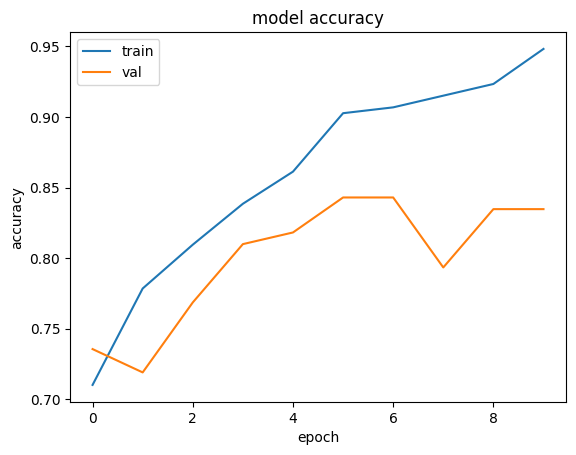

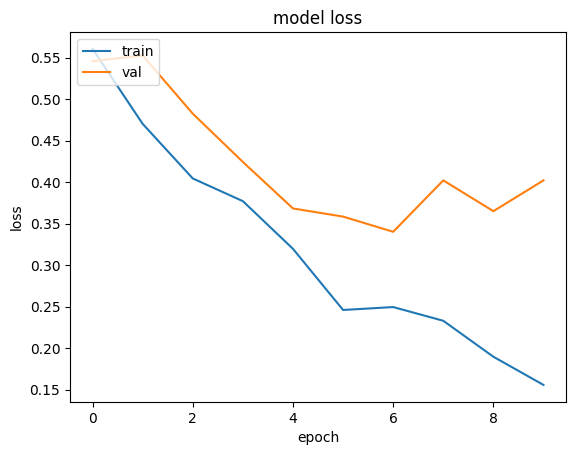

In [92]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



## Test Data Evaluation
In the following steps, the trained model will be utilized to classify the images in the test set. Subsequently, we will showcase the results through the use of a confusion matrix and a receiver operating characteristic (ROC) curve. With the use of this code, we take the continuous predictions generated by the model and apply a threshold of 0.5. This thresholding process transforms the predictions into binary class predictions. When a prediction is above 0.5, it's categorized as belonging to the positive class (hemmorhage); otherwise, it's categorized as the negative class (non-hemorrhage).

In [93]:
# Prediction on test data
prediction_test=model.predict(x_test)
y_pred_test = np.where(prediction_test > 0.5, 1, 0)

5/5 [==============================] - 0s 51ms/step


### Confusion Matrix
A confusion matrix is a table that summarizes the performance of a classification model. It shows the number of true positive, true negative, false positive, and false negative predictions. This helps in assessing how well the model is classifying instances for each class. From the confusion matrix, various metrics like accuracy, precision, recall, and F1-score can be calculated to evaluate the model's performance.

[[81 14]
 [ 9 47]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        95
           1       0.77      0.84      0.80        56

    accuracy                           0.85       151
   macro avg       0.84      0.85      0.84       151
weighted avg       0.85      0.85      0.85       151



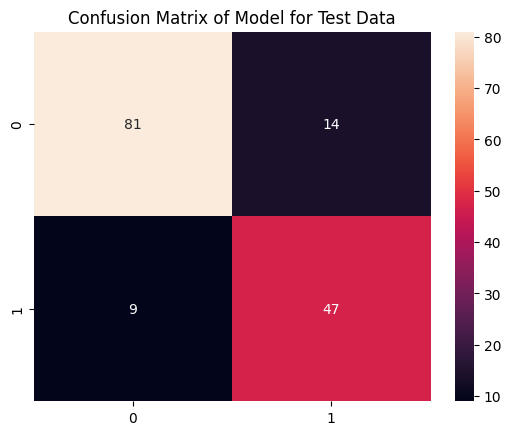

In [94]:
# Define the true class for each image in the test data
y_true_test=y_test

# Confusion matrix
cm_test=confusion_matrix(y_true_test,y_pred_test)
print(cm_test)
sns.heatmap(cm_test,annot=True).set_title('Confusion Matrix of Model for Test Data')
print(classification_report(y_true_test,y_pred_test))

### ROC Curve
The ROC curve is a graphical representation that shows the trade-off between a binary classification model's ability to correctly classify positive instances (sensitivity) and its tendency to incorrectly classify negative instances as positive (1 - specificity). It's a way to visualize and evaluate a model's performance at different classification thresholds. The area under the ROC curve (AUC-ROC) summarizes the overall performance: higher values indicate better performance, with 1 being ideal and 0.5 indicating random guessing.

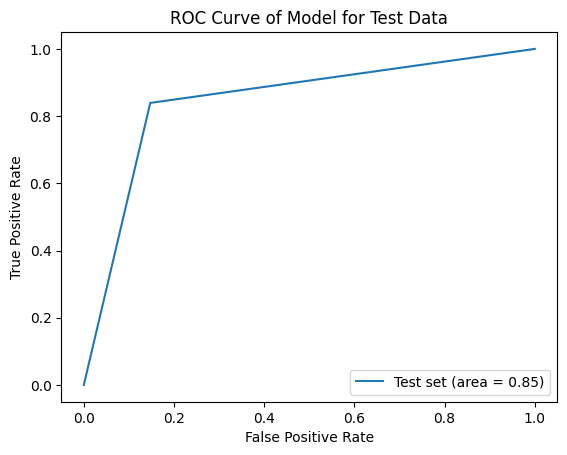

In [95]:
# ROC Curve of Model for Test Data
fpr, tpr,_ = roc_curve(y_true_test, y_pred_test)
auc = roc_auc_score(y_true_test, y_pred_test)

plt.plot(fpr,tpr,label='Test set (area = {:.2f})'.format(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve of Model for Test Data')
plt.show()

### Applying Model on Vlidation Data

4/4 [==============================] - 0s 52ms/step
[[58 10]
 [10 43]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        68
           1       0.81      0.81      0.81        53

    accuracy                           0.83       121
   macro avg       0.83      0.83      0.83       121
weighted avg       0.83      0.83      0.83       121



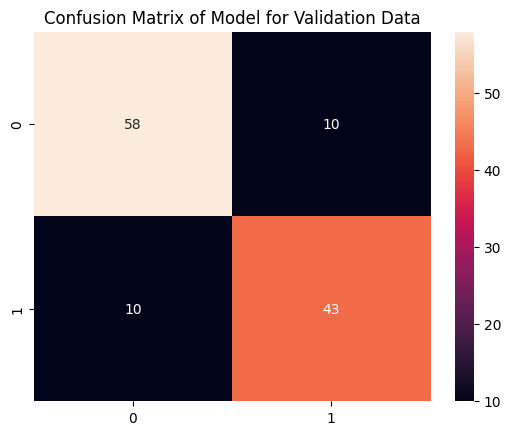

In [96]:
# Prediction on validation data
prediction_val=model.predict(x_val)
y_pred_val = np.where(prediction_val > 0.5, 1, 0)

# Define the true class for each image in the validation data
y_true_val=y_val

# Confusion matrix
cm_val=confusion_matrix(y_true_val,y_pred_val)
print(cm_val)
sns.heatmap(cm_val,annot=True).set_title('Confusion Matrix of Model for Validation Data')
print(classification_report(y_true_val,y_pred_val))

### Applying Model on Train Data

16/16 [==============================] - 1s 45ms/step
[[265   9]
 [  8 201]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       274
           1       0.96      0.96      0.96       209

    accuracy                           0.96       483
   macro avg       0.96      0.96      0.96       483
weighted avg       0.96      0.96      0.96       483



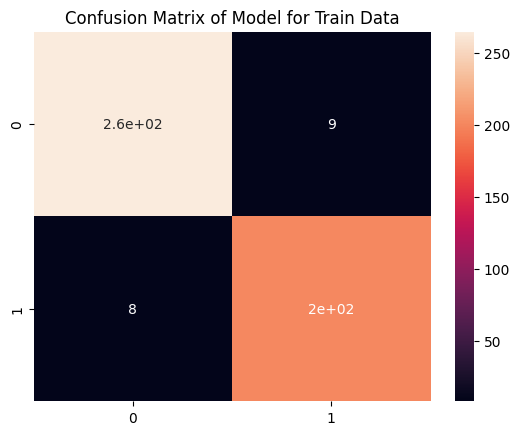

In [97]:
# Prediction on train data
prediction_train=model.predict(x_train)
y_pred_train = np.where(prediction_train > 0.5, 1, 0)

# Define the true class for each image in the train data
y_true_train=y_train

# Confusion matrix
cm_train=confusion_matrix(y_true_train,y_pred_train)
print(cm_train)
sns.heatmap(cm_train,annot=True).set_title('Confusion Matrix of Model for Train Data')
print(classification_report(y_true_train,y_pred_train))

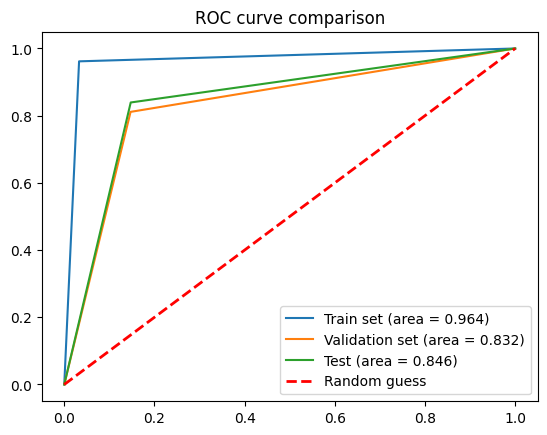

In [98]:
# Roc Comparison
plt.figure().clf()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_train, y_pred_train)
auc1 = roc_auc_score(y_true_train, y_pred_train)
plt.plot(fpr_keras, tpr_keras, label='Train set (area = {:.3f})'.format(auc1))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_val, y_pred_val)
auc2 = roc_auc_score(y_true_val, y_pred_val)
plt.plot(fpr_keras, tpr_keras, label='Validation set (area = {:.3f})'.format(auc2))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_test, y_pred_test)
auc3 = roc_auc_score(y_true_test, y_pred_test)
plt.plot(fpr_keras, tpr_keras, label='Test (area = {:.3f})'.format(auc3))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title("ROC curve comparison")
plt.legend(loc=0)

### Bibliography

Bhandari, A. (2023). Image Augmentation on the fly using Keras ImageDataGenerator! analytics vidhya.
https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

Versloot, C.(2022). *how to use k-fold cross validation with keras*.
github. Retrieved August 12, 2023, from https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md


